# Plot scan

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

#### Create txname/process translator

In [2]:
processDict = {'T2tt' : r'$\tilde{t} \, \tilde{t}, \tilde{t} \to t \chi$',
              'T2bbffff' : r'$\tilde{t} \, \tilde{t}, \tilde{t} \to b W^* \chi$',
              'T2bbWW' : r'$\tilde{t} \, \tilde{t}, \tilde{t} \to b W \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    #Remove off-shell Ws and Zs from ATLAS analyses (since they only appear in on-shell cases)
    if 'ATLAS' in newlabel:
        newlabel = newlabel.replace('W^{(*)} Z^{(*)}', 'W Z')
    return newlabel

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('sms_scan.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

#### Add c*tau and deltaM columns

In [6]:
dataDF['ctau.5000002'] = 1.967e-16/dataDF['width.5000002']
dataDF['deltaM'] = dataDF['mass.5000002']-dataDF['mass.5000012']

### Get points excluded:

In [7]:
excluded = dataDF[dataDF['excludedLHC'] == True]
allowed = dataDF[(dataDF['excludedLHC'] == False)]

print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 63
Total excluded (LHC) = 48
Total allowed = 15



### Create analysis label for excluded points

In [8]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    labels.append(label)
excluded['label'] = labels


In [9]:
nexcluded = [[len(excluded[excluded['label'] == label]),label] for label in excluded['label'].unique()]
nexcluded = sorted(nexcluded,reverse=True)
nexcluded = np.array(nexcluded)
for label in nexcluded[:,1]:
    print(label+': %i'%len(excluded[excluded['label'] == label]))

CMS-SUS-20-002 (T2tt): 17
CMS-SUS-19-006-agg (T2tt): 12
ATLAS-SUSY-2018-12 (T2bbffff): 11
CMS-SUS-16-033 (T2tt): 3
CMS-PAS-SUS-16-052 (T2bbWW): 3
CMS-SUS-17-010 (T2tt): 1
CMS-SUS-16-049 (T2ttC): 1


### Define colors and plotting order

In [10]:
colors = sns.color_palette("Paired",len(excluded['label'].unique()))
colorsPink = sns.color_palette("colorblind",8)
colorDict = {'CMS-SUS-20-002 (T2tt)' : colorsPink[4], #light pink
             'CMS-SUS-16-033 (T2tt)' : colors[5], #red
             'CMS-SUS-19-006-agg (T2tt)' : colors[1], #dark blue
             'ATLAS-SUSY-2018-12 (T2bbffff)' : colors[3], #dark green
             'CMS-PAS-SUS-16-052 (T2bbWW)' : colors[0], #light blue
             'Other' : colors[5] #dark purple
             }
#Define plotting order:
plottingOrder = nexcluded[:,1]
#Add other analyses
for ana in excluded['label'].unique():
    if not ana in plottingOrder:
        plottingOrder.append(ana)

### Get monojet exclusion curve

In [25]:
monoJet = np.genfromtxt('../Recast/monojet_curve.csv',delimiter=',',skip_header=1)

### Stop lifetime

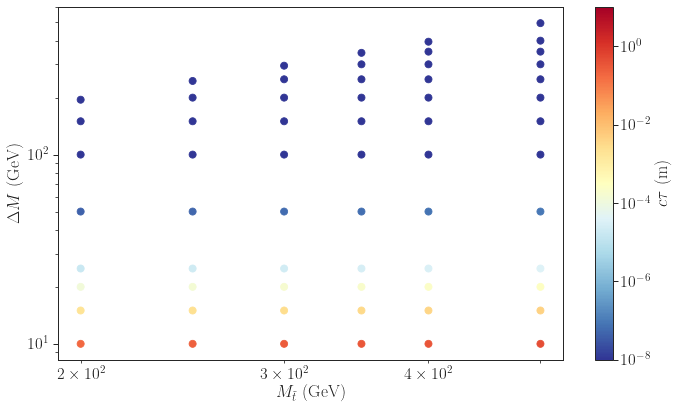

In [26]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))
x = dataDF['mass.5000002']
y = dataDF['deltaM']
c = dataDF['ctau.5000002']
x = x[c.argsort()]
y = y[c.argsort()]
c = c[c.argsort()]

plt.scatter(x,y,c=c,s=50,cmap=cm, norm=LogNorm(vmin=1e-8,vmax=10))
# plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$c\tau$ (m)')
plt.xlabel(r'$M_{\tilde{t}}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
# plt.ylim(-1,10)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.savefig('stopLifetime.png')
plt.show()

In [27]:
print(dataDF['ctau.5000002'].max())

0.44172467999101733


### Plot excluded points grouped by most excluding analysis

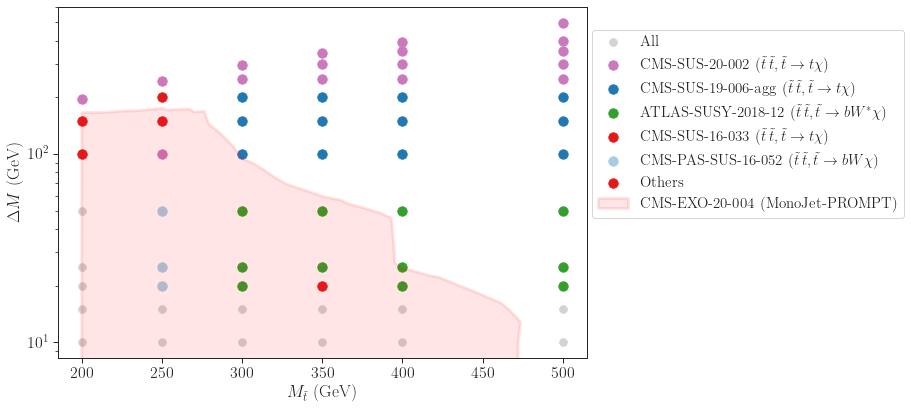

In [33]:
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(13,6))

x = allowed['mass.5000002']
y = allowed['deltaM']
c_other = 'lightgray'
plt.scatter(x,y,color=c_other,label='All',s=60)

otherLabel = 'Others'
for ana in plottingOrder:
    x = excluded[excluded['label'] == ana]['mass.5000002']
    y = excluded[excluded['label'] == ana]['deltaM']
    if not ana in colorDict:
        color = colorDict['Other']        
        plt.scatter(x,y,color=color,label=otherLabel,s=90)
        otherLabel = None #suppress repeated label
    else:
        color = colorDict[ana]
        label = convertLabel(ana)
        plt.scatter(x,y,color=color,label=label,s=90)

# Add exclusion curves
plt.fill_between(monoJet[0],monoJet[0]-monoJet[1],label='CMS-EXO-20-004 (MonoJet-PROMPT)',linewidth=3,
                 linestyle='-',color='red',alpha=0.1)
# offExc = excCurves['CMS-EXO-19-010 (TDTM1F,TDTM2F)']
# c = colorDict['CMS-EXO-19-010 (TDTM1F,TDTM2F)']
# plt.plot(offExc[:,0],offExc[:,1],label='CMS-EXO-19-010 (DT)',linewidth=3,linestyle='--',color='black')

lgd = plt.legend(loc=(1.01,0.4), framealpha=1.,fontsize=15)
plt.yscale('log')
# plt.ylim(1,30)
# plt.ylim(1e-2,0.1)
# plt.xlim(0,1000)
# plt.xticks([0,200.,300.,400.,450.,500.,550.])
# plt.grid()
plt.xlabel(r'$M_{\tilde{t}}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
# plt.yticks([1e-16,1e-14,1e-12,1e-10,1e-8,1e-6,1e-4,1e-2,1e0])
plt.tight_layout()
plt.savefig('stop_exclusion_deltaM.png')
plt.show()